# Pediatric Bone Age Detection using Hand X-ray
Bone age is an indicator of skeletal maturity. A child’s bone age may or may not exactly match with the child’s age according to his or her birth date. Many factors, such as, nutrition, genetics, hormones, and disease states, influence the development of the skeletal [1]. The bone age study can tell how fast or slowly a child’s skeleton is maturing [2] and it can also provide useful information on many clinical concerns. Clinicians use bone age assessment in order to evaluate the maturity of a child’s skeletal system [3]. Applications that utilize assessment of the skeletal maturity are ever growing. In addition to the medical application, the skeletal maturity assessment can be used in sports selection and forensics to the international immigrant. For example, many children seeking asylum are required to undergo a bone age study so that required resources can be facilitated for them [1].

Data set provided in the [Pediatric Bone Age Challenge(2017)](https://www.rsna.org/en/education/ai-resources-and-training/ai-image-challenge/RSNA-Pediatric-Bone-Age-Challenge-2017) organized by the Radiological Society of North America (RSNA) are used for the child’s bone age prediction. The data set can be downloaded [here](https://stanfordmedicine.app.box.com/s/4r1zwio6z6lrzk7zw3fro7ql5mnoupcv) and includes
* 12,611 hand radiographs for training
* 1,425 hand radiographs for validation
* 200 hand radiographs for testing
* A CSV file with skeletal age estimates and sex of the training and validation images labeled from the accompanying clinical radiology report provided at the time of imaging, and a separate CSV file containing skeletal age estimates and sex of the test images.

#### References
[1] https://pediatrics.aappublications.org/content/140/6/e20171486

[2] https://kidshealth.org/en/parents/xray-bone-age.html

[3] Vladimir Iglovikov, Alexander Rakhlin, Alexandr A. Kalinin, Alexey Shvets “Pediatric Bone Age Assessment Using Deep Convolutional Neural Networks”, bioRxiv 234120


### Problem statement
I am trying to answer the following two quesitons in this work.
* Which model classification or regression neural net provides better age prediction?
* Do two separate models for male and female provide better age prediction comapred to a single model for both?

In order to answer the above questions, the following models will be trained 

* Classification convolution neural net model will be trained on the traning data and skeletel age of the testing data will be predicted.
*Regression convolution neural net model will be trained on the training data and skeletel age of the testing data will be predicted.
*Best of the classification and regression convolution neural net model will be trained on the male training data and skeletel age of the of male testing data will be predicted.
*Best of the classification and regression convolution neural net model will be trained on the female training data and skeletel age of the of female testing data will be predicted.
* Results of all the above models will be analyzed and best model will be determined.

Mount google drive to get access to the data

In [1]:
# from google.colab import drive
# drive.mount('/content/drive/')

In [72]:
import numpy as np 
import pandas as pd
import tensorflow as tf
import datetime, os
import math
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")
import multiprocessing as mp # multiprocessing
import matplotlib.image as mpimg #image reading 
from matplotlib.cbook import flatten # flatten list

## 1. **Data clean up and exploration**<br>
Read training and test CSV files. The train CSV contains three columns (id, boneage, and male) and 12,611 rows. The test CSV file contains two columns(Case ID and Sex) and 200 rows. None of the rows has null value.


In [3]:
# CSV file and iamge directories

# CSV file path + name
csv_train = '/storage/capstone_data/train.csv'
csv_valid = '/storage/capstone_data/validation.csv'
csv_test = '/storage/capstone_data/Bone-age-ground-truth.csv'

# Image data directories
# Original data directory- before pre-processing (for image preprocessing)

train_img_pre = '/storage/capstone_data/train_image/'
valid_img_pre = '/storage/capstone_data/valid_image/'
test_img_pre = '/storage/capstone_data/test/test/'

#Data directory after pre-processing (for the tarining)

train_img_dir = '/storage/capstone_data/train_preprocess/'
valid_img_dir = '/storage/capstone_data/valid_preprocess/'
test_img_dir = '/storage/capstone_data/test_preprocess/'
# train_img_dir = '/storage/capstone_data/train_image/'
# valid_img_dir = '/storage/capstone_data/valid_image/'
# test_img_dir  = '/storage/capstone_data/test/'

# Save pre-processed images
train_save_dir = '/storage/capstone_data/train_preprocess/'
valid_save_dir = '/storage/capstone_data/valid_preprocess/'
test_save_dir = '/storage/capstone_data/test_preprocess/test/'

In [4]:
#loading dataframes
train_df = pd.read_csv(csv_train, nrows = 12608)
valid_df = pd.read_csv(csv_valid, nrows = 1408)
test_df = pd.read_csv(csv_test, nrows = 192)

In [5]:
# Trian CSV file header
print (train_df.head())

     id  boneage   male
0  1377      180  False
1  1378       12  False
2  1379       94  False
3  1380      120   True
4  1381       82  False


In [6]:
# Validation CSV file header
print (valid_df.head())

   Image ID   male  Bone Age (months)
0      1386  False                 30
1      1392   True                162
2      1397  False                 18
3      1401  False                132
4      1410   True                 57


In [7]:
# Test CSV file header
print (test_df.head())

   Case ID Sex  Ground truth bone age (months)
0     4360   M                          168.93
1     4361   M                          169.65
2     4362   M                           73.26
3     4363   M                          152.86
4     4364   M                          135.46


In [8]:
# train CSV file info
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12608 entries, 0 to 12607
Data columns (total 3 columns):
id         12608 non-null int64
boneage    12608 non-null int64
male       12608 non-null bool
dtypes: bool(1), int64(2)
memory usage: 209.4 KB


In [9]:
# Valid CSV file info
valid_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1408 entries, 0 to 1407
Data columns (total 3 columns):
Image ID             1408 non-null int64
male                 1408 non-null bool
Bone Age (months)    1408 non-null int64
dtypes: bool(1), int64(2)
memory usage: 23.5 KB


In [10]:
# Test CSV file info
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 192 entries, 0 to 191
Data columns (total 3 columns):
Case ID                           192 non-null int64
Sex                               192 non-null object
Ground truth bone age (months)    192 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 4.6+ KB


#### Create image file names by appending '.png' file extension to the id column

In [11]:
train_df['id'] = train_df['id'].apply(lambda x: str(x)+'.png')
valid_df['Image ID'] = valid_df['Image ID'].apply(lambda x: str(x)+'.png')
test_df['Case ID'] = test_df['Case ID'].apply(lambda x: str(x)+'.png') 
train_df.head()

,id,boneage,male
0,1377.png,180,False
1,1378.png,12,False
2,1379.png,94,False
3,1380.png,120,True
4,1381.png,82,False


In [12]:
valid_df.head()

,Image ID,male,Bone Age (months)
0,1386.png,False,30
1,1392.png,True,162
2,1397.png,False,18
3,1401.png,False,132
4,1410.png,True,57


### Create male-only and female-only DataFrame

In [13]:
# Dataframe for male only children
train_df_male = train_df[train_df['male']==True]
valid_df_male = valid_df[valid_df['male']==True]
train_df_male.head()

,id,boneage,male
3,1380.png,120,True
5,1382.png,138,True
6,1383.png,150,True
7,1384.png,156,True
8,1385.png,36,True


In [14]:
# Dataframe for male only children
train_df_female = train_df[train_df['male']==False]
valid_df_female = valid_df[valid_df['male']==False]
train_df_female.head()

,id,boneage,male
0,1377.png,180,False
1,1378.png,12,False
2,1379.png,94,False
4,1381.png,82,False
10,1388.png,126,False


In [15]:
# Male-only Dataframe info
print (train_df_male.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6831 entries, 3 to 12605
Data columns (total 3 columns):
id         6831 non-null object
boneage    6831 non-null int64
male       6831 non-null bool
dtypes: bool(1), int64(1), object(1)
memory usage: 166.8+ KB
None


In [16]:
# Female-only dataframe info
print (train_df_female.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5777 entries, 0 to 12607
Data columns (total 3 columns):
id         5777 non-null object
boneage    5777 non-null int64
male       5777 non-null bool
dtypes: bool(1), int64(1), object(1)
memory usage: 141.0+ KB
None


**Some EDA- finding out male and female populaiton**

male      6831
female    5777
Name: Sex, dtype: int64


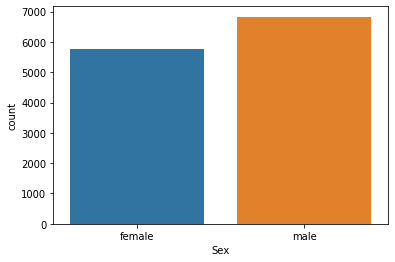

In [17]:
train_df['Sex'] = train_df['male'].apply(lambda x: 'male' if x else 'female')
valid_df['Sex'] = valid_df['male'].apply(lambda x: 'male' if x else 'female')
print(train_df['Sex'].value_counts())
sns.countplot(x = train_df['Sex'])

In [18]:
# Min, Max, and Mean of the childage in training data
train_df.describe()

,boneage
count,12608.000000
mean,127.324318
std,41.181368
min,1.000000
25%,96.000000
50%,132.000000
75%,156.000000
max,228.000000


In [19]:
# Feature normalization- total population
mean_age = train_df.boneage.mean()
std_age = train_df.boneage.std()
train_df['scale_bone_age_z'] = (train_df['boneage'] - mean_age)/(std_age)
valid_df['scale_bone_age_z'] = (valid_df['Bone Age (months)'] - mean_age)/(std_age)
train_df.head()

,id,boneage,male,Sex,scale_bone_age_z
0,1377.png,180,False,female,1.279114
1,1378.png,12,False,female,-2.800400
2,1379.png,94,False,female,-0.809209
3,1380.png,120,True,male,-0.177855
4,1381.png,82,False,female,-1.100603


In [20]:
# Feature normalization- male population
mean_age_male = train_df_male.boneage.mean()
std_age_male = train_df_male.boneage.std()
train_df_male['scale_bone_age_z'] = (train_df_male['boneage'] - mean_age_male)/(std_age_male)
valid_df_male['scale_bone_age_z'] = (valid_df_male['Bone Age (months)'] - mean_age)/(std_age)
train_df_male.head()

,id,boneage,male,scale_bone_age_z
3,1380.png,120,True,-0.363046
5,1382.png,138,True,0.064011
6,1383.png,150,True,0.348716
7,1384.png,156,True,0.491068
8,1385.png,36,True,-2.355979


In [21]:
# Feature normalization- male population
mean_age_female = train_df_female.boneage.mean()
std_age_female = train_df_female.boneage.std()
train_df_female['scale_bone_age_z'] = (train_df_female['boneage'] - mean_age_female)/(std_age_female)
valid_df_female['scale_bone_age_z'] = (valid_df_female['Bone Age (months)'] - mean_age)/(std_age)
train_df_female.head()

,id,boneage,male,scale_bone_age_z
0,1377.png,180,False,1.638655
1,1378.png,12,False,-2.793787
2,1379.png,94,False,-0.630333
4,1381.png,82,False,-0.946936
10,1388.png,126,False,0.213941


Text(0.5, 1.0, '# of children vs age')

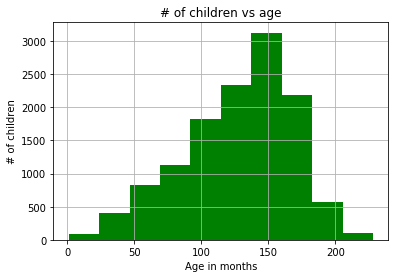

In [22]:
# Plotting a histogram for train bone ages
train_df['boneage'].hist(color = 'green')
plt.xlabel('Age in months')
plt.ylabel('# of children')
plt.title('# of children vs age')

Text(0.5, 1.0, '# of children vs bone age z score')

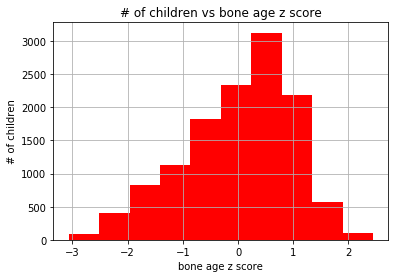

In [23]:
# Plotting a histogram for train bone ages (z-score)
train_df['scale_bone_age_z'].hist(color = 'red')
plt.xlabel('bone age z score')
plt.ylabel('# of children')
plt.title('# of children vs bone age z score')

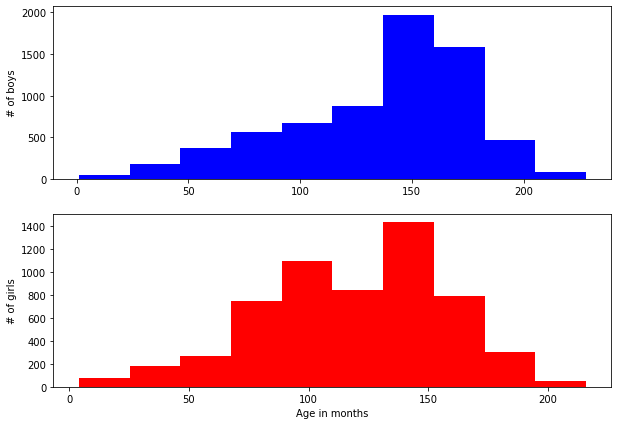

In [24]:
# Distribution of age within each gender 
male = train_df[train_df['Sex'] == 'male']
female = train_df[train_df['Sex'] == 'female']
fig, ax = plt.subplots(2,1)
ax[0].hist(male['boneage'], color = 'blue')
ax[0].set_ylabel('# of boys')
ax[1].hist(female['boneage'], color = 'red')
ax[1].set_xlabel('Age in months')
ax[1].set_ylabel('# of girls')
fig.set_size_inches((10,7))

### 2. Upload and Check if any training/validation image is corrupted or missing
#### --->Uncomment next two cells for the first time and comment back when images are verified

In [25]:
# import matplotlib.image as mpimg
# import os.path
# for filename, boneage, gender in train_df[['id','boneage','Sex']].values:
#     if not os.path.isfile(train_img_dir + filename): 
#         print ('This file does not exist-' + filename)
#     else:
#         try: img = mpimg.imread(train_img_dir + filename)
#         except OSError: print (filename)            

In [26]:
# Check if any valid image file is corrupted or missing

# for filename, boneage, gender in valid_df[['Image ID','Bone Age (months)','Sex']].values:
#     if not os.path.isfile(valid_img_dir + filename): 
#         print ('This file does not exist-' + filename)
#     else:
#         try: img = mpimg.imread(valid_img_dir + filename)
#         except OSError: print (filename)

### 3. Image preprocessing using Kmeans clustering (two iterations)
First iteration is not sufficient to remove all background noise. Therefore, two iterations are used for the preprocessing. Pre-processed images are saved in different directory from the original images. So, cells belongs to pre-processing are not required to run every single time. Comment next few cells releated to pre-processing after first pre-processing is done.

1. Orignal image height is reduced to 2*image_size and width is also reduced to keep the same aspect ratio.
2. Image pixels are classified in n cluters (defined by n_clusters below) using K-means clustering.
3. Pixels from first four clusters are included to creat a mask. Only clusters meeting total pixel counts defined below are included.
4. Image is cropped to include only the mask region and then zero paded to make it square.
5. Image (height and width) is resized to 2*image_size to get similar size image as in step 2 so that same pixel counts requirments
work for the next iteration.
6. Step 2-4 are repeated.
7. Image (height and width) is resized to image_size.

In [27]:
# Import required modules=====================
from skimage.color import rgb2gray
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.cluster import KMeans
from PIL import Image
import timeit
#============================================

In [28]:
# Input parameters============================
n_clusters = 6 #4
image_size = 256

In [29]:
def image_segmentain(img_flat):

  kmeans = KMeans(n_clusters = n_clusters, random_state = 0).fit(img_flat.reshape(-1,1))  
  """Kmeans lables had issue with masking so center of each cluster
    is assigned for corresponding labels"""
    
  kmeans_centers = kmeans.cluster_centers_[kmeans.labels_]
  
  return  kmeans_centers.flatten()

In [30]:
def image_mask(kmeans_labels, img_gray_orig):

  mask_img = np.zeros((img_gray_orig.shape[0], img_gray_orig.shape[1]))
  kmeans_labels_arr = kmeans_labels.reshape(img_gray_orig.shape[0], img_gray_orig.shape[1])
    
  sort_labels = sorted(pd.Series(kmeans_labels).unique(), reverse = True)
  just_bone = ()
   
  if (np.sum(kmeans_labels_arr==sort_labels[0])) > 8000:
        just_bone = np.where(kmeans_labels_arr==sort_labels[0])
        mask_img[just_bone] = 1
#         print('test1')
                
  if (np.sum(kmeans_labels_arr==sort_labels[1])) > 8000 and (np.sum(kmeans_labels_arr==sort_labels[1])) < 60000:
        just_bone = np.where(kmeans_labels_arr==sort_labels[1])
        mask_img[just_bone] = 1
#         print('test2')
  if (np.sum(kmeans_labels_arr==sort_labels[2]))>8000 and (np.sum(kmeans_labels_arr==sort_labels[2])) < 70000:
        just_bone = np.where(kmeans_labels_arr==sort_labels[2])
        mask_img[just_bone] = 1
#         print('test3')
  if (np.sum(kmeans_labels_arr==sort_labels[3]))>8000 and (np.sum(kmeans_labels_arr==sort_labels[3])) < 70000:
        just_bone = np.where(kmeans_labels_arr==sort_labels[3])
        mask_img[just_bone] = 1
#         print('test4')
  if not just_bone:
    just_bone = np.where(kmeans_labels_arr==sort_labels[1]) 
    mask_img[just_bone] = 1
#     print('test4')

#   plt.imshow(mask_img)
#   plt.show()
  return just_bone, mask_img


In [31]:
def img_resize(img, img_height):

  img_width  = int(img_height*img.shape[1]/img.shape[0])

  img_pil = Image.fromarray(img) # convert array back to image
  
  img_pil_resize = img_pil.resize((img_width, img_height), Image.LANCZOS) # resize

  return np.array(img_pil_resize)

In [32]:
def img_pad_resize(img_just_bone, image_size):

  
  size_diff = img_just_bone.shape[0]-img_just_bone.shape[1]

  if size_diff > 0: # hieght is longer than width
    top = 0
    bottom = 0
    left = int(abs(size_diff)/2.)
    right = (abs(size_diff)-left)
  elif size_diff < 0: # hieght is shorter than width
    left = 0
    right = 0
    top = int(abs(size_diff)/2.)
    bottom = (abs(size_diff)-top)
  else:
    top = 0
    bottom = 0
    left = 0
    right = 0

  img_bone_square = np.pad (img_just_bone,((top,bottom),(left,right)), 'constant')

  img_bone = img_resize(img_bone_square, image_size)
    
#   plt.imshow(img_bone)
#   plt.show()
  
  return img_bone

In [33]:
def img_preprocess_core(img_gray_orig):
    
    img_flat = img_gray_orig.reshape(img_gray_orig.shape[0] * img_gray_orig.shape[1])
         
    kmeans_labels =  image_segmentain(img_flat)
    
    kmeans_labels_arr = kmeans_labels.reshape(img_gray_orig.shape[0], img_gray_orig.shape[1])

    just_bone, mask_img = image_mask (kmeans_labels, img_gray_orig)
       
    img_clean_background = mask_img * img_gray_orig

    img_just_bone = img_clean_background[min(just_bone[0]):max(just_bone[0]),\
                                         min(just_bone[1]):max(just_bone[1])]
    return img_just_bone

In [34]:
def img_preprocessing(save_path,img_path, filename):
       
    save_path_filename = save_path + filename
   
    image = plt.imread(img_path + filename)
    img_gray_orig_0 = rgb2gray(image)
    
#     plt.imshow(img_gray_orig_0)
#     plt.show()
    img_gray_orig = img_resize(img_gray_orig_0, 2*image_size)
    
    img_just_bone = img_preprocess_core(img_gray_orig)
    
    try:
        img_bone = img_pad_resize(img_just_bone, 2*image_size) 
         #Second iteration of image segmentation
        img_just_bone = img_preprocess_core(img_bone)
        img_bone = img_pad_resize(img_just_bone, image_size)

        plt.imsave(save_path_filename, img_bone)
        
    except ValueError:
        print (filename)
    
#     print (sorted(pd.Series(kmeans_labels).unique(), reverse = True))
#     print (pd.Series(kmeans_labels).value_counts())       


#### Multiprocessing model to speed up the preprocessing
##### Pre-processing train images

In [35]:
# def multi_run_wrapper(args):
#    return img_preprocessing(*args)

# def main():
 
#   pool = mp.Pool(mp.cpu_count())
#   result = pool.map(multi_run_wrapper,[(train_save_dir,train_img_pre, fname) for fname in train_df['id'].values])

# if __name__ == "__main__":
#     start = timeit.default_timer()
#     main()
    
#     stop = timeit.default_timer()
#     print('Time in (sec): ', stop - start)  

##### Pre-processing validation images

In [36]:
# def multi_run_wrapper(args):
#    return img_preprocessing(*args)

# def main():
 
#   pool = mp.Pool(mp.cpu_count())
#   result = pool.map(multi_run_wrapper,[(valid_save_dir,valid_img_pre, fname) for fname in valid_df['Image ID'].values])

# if __name__ == "__main__":
#     start = timeit.default_timer()
#     main()
    
#     stop = timeit.default_timer()
#     print('Time in (sec): ', stop - start)

#####  Pre-processing test images    

In [37]:
# def multi_run_wrapper(args):
#    return img_preprocessing(*args)

# def main():
 
#   pool = mp.Pool(mp.cpu_count())
#   result = pool.map(multi_run_wrapper,[(test_save_dir, test_img_pre, fname) for fname in test_df['Case ID'].values])

# if __name__ == "__main__":
#     start = timeit.default_timer()
#     main()
    
#     stop = timeit.default_timer()
#     print('Time in (sec): ', stop - start)

##### Without multiprocessing (serial operation)

In [38]:
# start = timeit.default_timer()

# for fname in ['1399.png']:#train_df['id'].values[0:16]:
#     img_preprocessing(fname)

# stop = timeit.default_timer()
# print('Time in (sec): ', stop - start) 

### 4. Visual inspection of some sample images

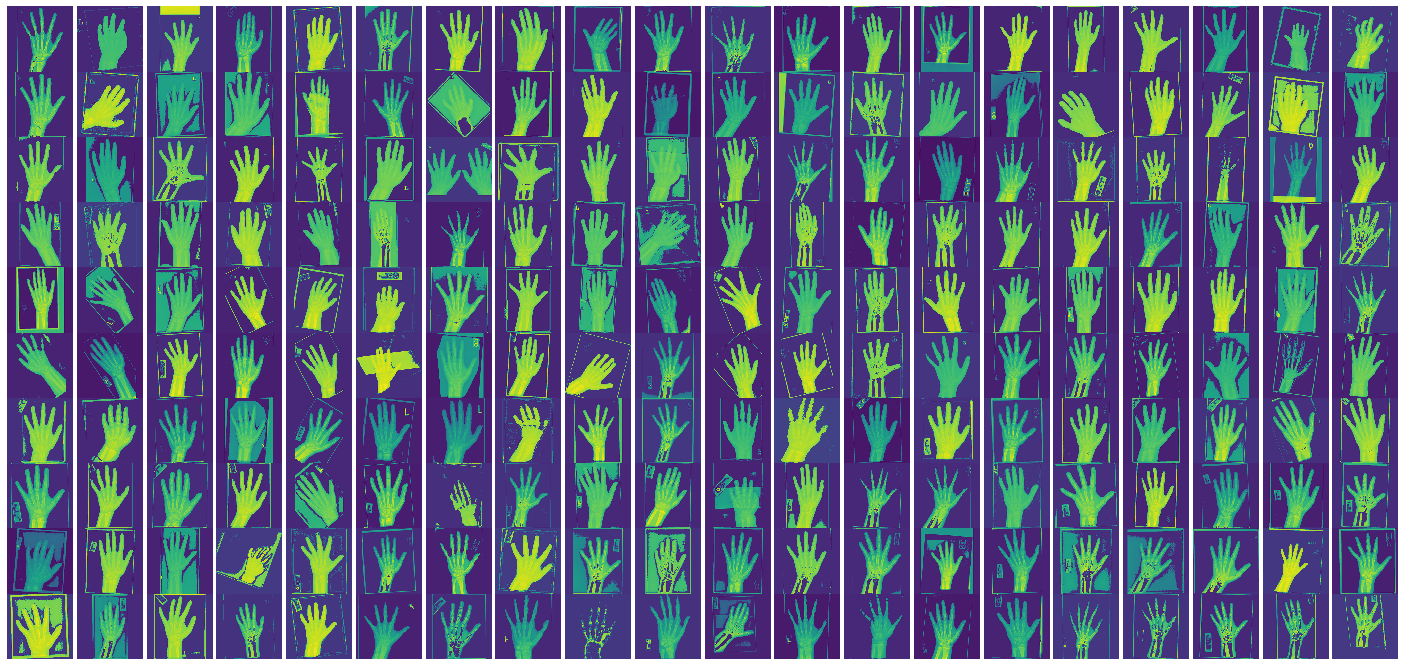

In [39]:
# Display some train images
fig, axs = plt.subplots(10,20, figsize=(25,12), facecolor='w', edgecolor='k')
plt_num =0
axs = axs.ravel()

for filename in train_df['id'][0:200].values:
    img = mpimg.imread(train_img_dir + filename)
    
    axs[plt_num].imshow(img)
#     axs[plt_num].set_title('file:{}'.format(filename))
    axs[plt_num].set_axis_off()
    plt_num += 1

plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

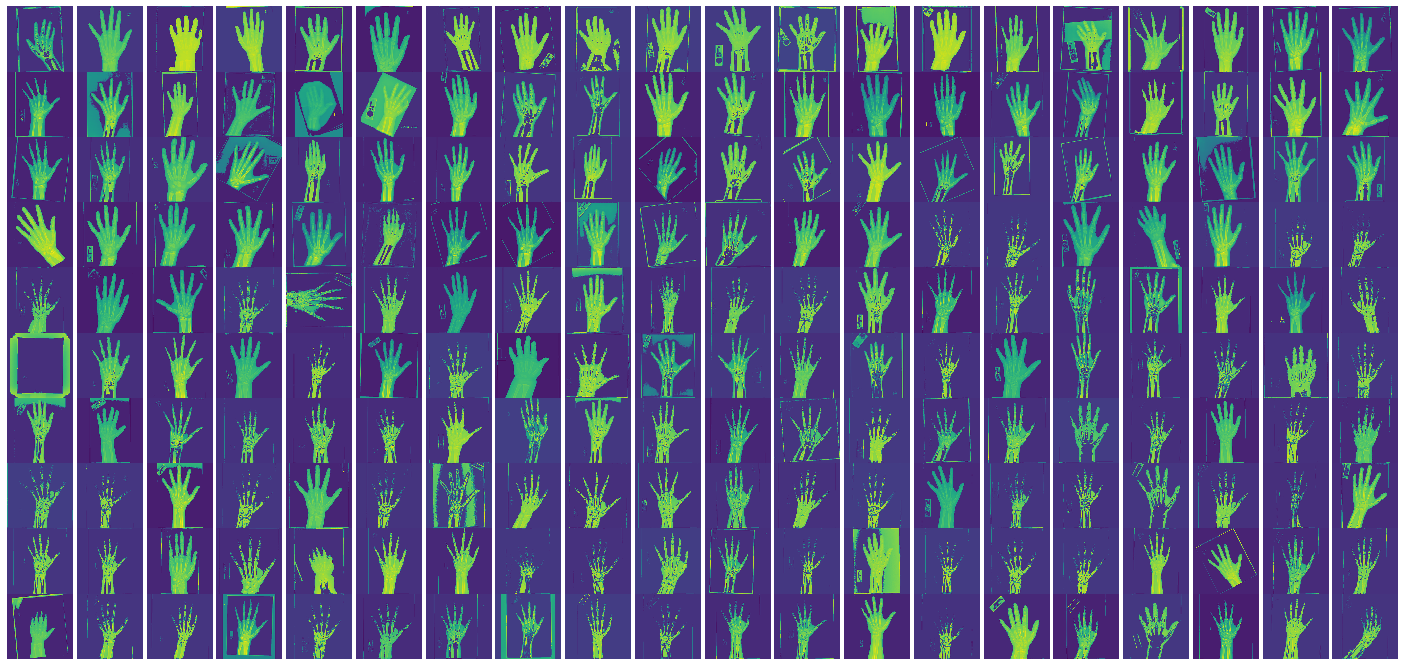

In [40]:
# Display some validation images
fig, axs = plt.subplots(10,20, figsize=(25,12), facecolor='w', edgecolor='k')
plt_num =0
axs = axs.ravel()

for filename in valid_df['Image ID'][0:200].values:
    img = mpimg.imread(valid_img_dir + filename)
    
    axs[plt_num].imshow(img)
#     axs[plt_num].set_title('file:{}'.format(filename))
    axs[plt_num].set_axis_off()
    plt_num += 1

plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

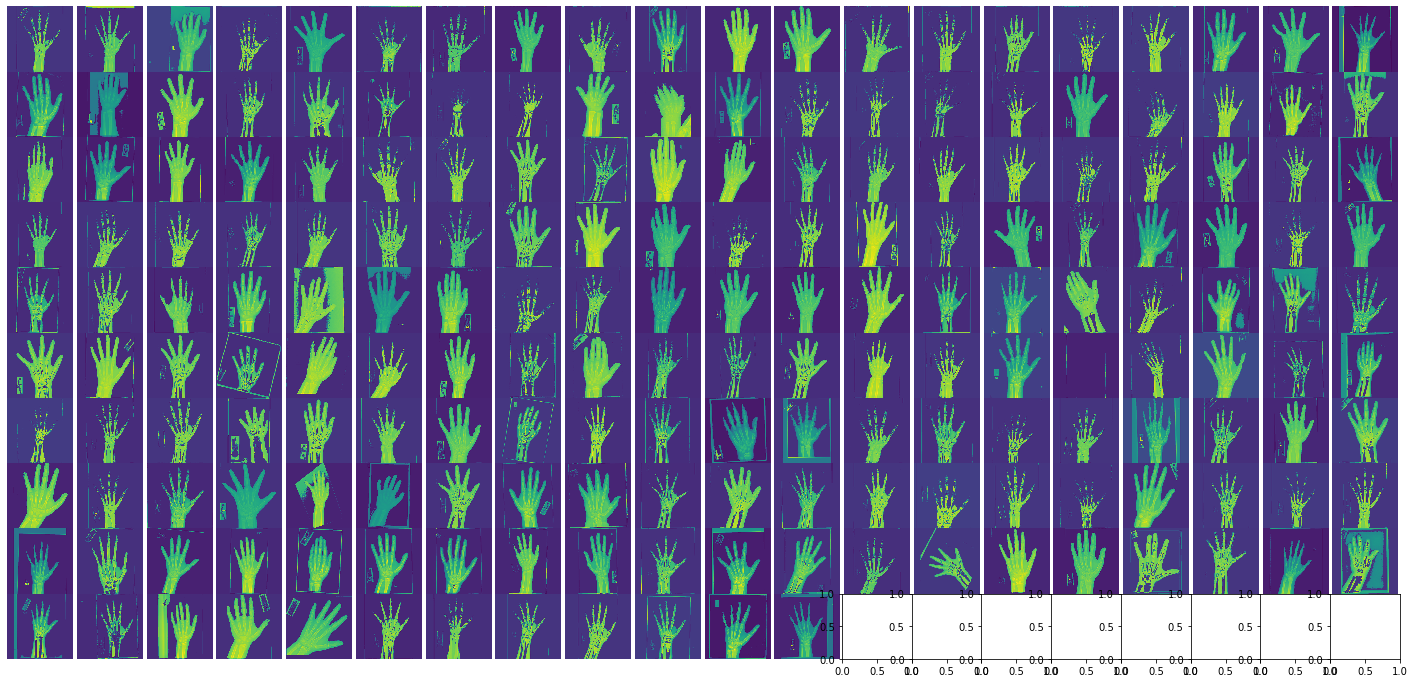

In [41]:
# Display some test images
fig, axs = plt.subplots(10,20, figsize=(25,12), facecolor='w', edgecolor='k')
plt_num =0
axs = axs.ravel()

for filename in test_df['Case ID'][0:200].values:
    img = mpimg.imread(test_img_dir + "test/"+ filename)
#     img = mpimg.imread(test_img_dir + filename)
    
    axs[plt_num].imshow(img)
#     axs[plt_num].set_title('file:{}'.format(filename))
    axs[plt_num].set_axis_off()
    plt_num += 1

plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

In [42]:
import keras
keras.__version__

Using TensorFlow backend.


'2.2.4'

In [43]:
import tensorflow
tensorflow.__version__

'2.0.0-dev20190814'

**Setting up Image Data Generators!**<br>
We use image data generators for both training, testing and preprocessing of images. Validation set is already broken off from training set. 

In [44]:
#library required for image preprocessing
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from  keras.applications.xception import preprocess_input 

#reducing down the size of the image 
img_size = 256
BATCH_SIZE = 32

train_data_generator = ImageDataGenerator(preprocessing_function = preprocess_input)
valid_data_generator = ImageDataGenerator(preprocessing_function = preprocess_input)

# train_data_generator = ImageDataGenerator(rescale=1./255, zoom_range=0.3, rotation_range=50,
#                                    width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, 
#                                    horizontal_flip=True, fill_mode='nearest')

# valid_data_generator = ImageDataGenerator(rescale=1./255)
#train data generator
train_generator = train_data_generator.flow_from_dataframe(
    dataframe = train_df,
    directory = train_img_dir,
    x_col= 'id',
    y_col= 'scale_bone_age_z',
    batch_size = BATCH_SIZE,
    seed = 42,
    shuffle = True,
    class_mode= 'raw',
    flip_vertical = True,
    color_mode = 'rgb',
    target_size = (img_size, img_size))

#validation data generator
valid_generator = valid_data_generator.flow_from_dataframe(
    dataframe = valid_df,
    directory = valid_img_dir,
    x_col = 'Image ID',
    y_col = 'scale_bone_age_z',
    batch_size = BATCH_SIZE,
    seed = 42,
    shuffle = True,
    class_mode = 'raw',
    flip_vertical = True,
    color_mode = 'rgb',
    target_size = (img_size, img_size))

#test data generator
test_data_generator = ImageDataGenerator(preprocessing_function = preprocess_input)

test_generator = test_data_generator.flow_from_directory(
    directory = test_img_dir,
    shuffle = False,
    class_mode = None,
    color_mode = 'rgb',
    target_size = (img_size,img_size))

# test_generator = test_data_generator.flow_from_dataframe(
#     dataframe = test_df,
#     directory = test_img_dir,
#     x_col = 'Case ID',
#     y_col = 'Ground truth bone age (months)',
#     batch_size = 200,
#     seed = 42,
#     shuffle = False,
#     class_mode = 'raw',
#     flip_vertical = True,
#     color_mode = 'rgb',
#     target_size = (img_size, img_size))

Found 12608 validated image filenames.
Found 1408 validated image filenames.
Found 200 images belonging to 2 classes.


Found 1 validated image filenames.


W1221 21:41:22.721692 140705732130624 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W1221 21:41:22.724828 140705732130624 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W1221 21:41:22.728230 140705732130624 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W1221 21:41:22.731261 140705732130624 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W1221 21:41:22.734233 140705732130624 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Labels: [1.2791144419327571, 1.2791144419327571, 1.2791144419327571, 1.2791144419327571, 1.2791144419327571]


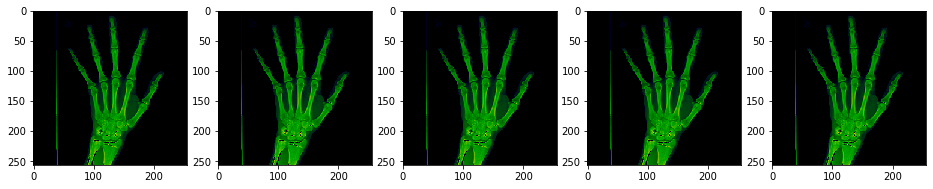

In [45]:
img_id = 2595
new_generator =  train_data_generator.flow_from_dataframe(
                                            dataframe = train_df.head(1),
                                            directory = train_img_dir,
                                            x_col= 'id',
                                            y_col= 'scale_bone_age_z',
                                            batch_size = 1,
                                            seed = 42,
                                            shuffle = True,
                                            class_mode= 'raw',
                                            flip_vertical = True,
                                            color_mode = 'rgb',
                                            target_size = (img_size, img_size))
new = [next(new_generator) for i in range(0,5)]
fig, ax = plt.subplots(1,5, figsize=(16, 6))
print('Labels:', [item[1][0] for item in new])
l = [ax[i].imshow(new[i][0][0]) for i in range(0,5)]

In [46]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
print (STEP_SIZE_TRAIN, STEP_SIZE_VALID,STEP_SIZE_TEST )

394 44 6


In [47]:
test_X, test_Y = next(valid_data_generator.flow_from_dataframe( 
                            valid_df, 
                            directory = valid_img_dir,
                            x_col = 'Image ID',
                            y_col = 'scale_bone_age_z', 
                            target_size = (img_size, img_size),
                            batch_size = 1024,
                            class_mode = 'raw'
                            )) 

Found 1408 validated image filenames.


 The function to plot training and validation error as a function of epochs

In [48]:
def plot_it(history):
    '''function to plot training and validation error'''
    fig, ax = plt.subplots( figsize=(20,10))
    ax.plot(history.history['mae_in_months'])
    ax.plot(history.history['val_mae_in_months'])
    plt.title('Model Error')
    plt.ylabel('error')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper right')
    ax.grid(color='black')
    plt.show()

In [49]:
from keras.metrics import mean_absolute_error
def mae_in_months(x_p, y_p):
    '''function to return mae in months'''
    return mean_absolute_error((std_age*x_p + mean_age), (std_age*y_p + mean_age)) 

### Pre-trained model- Xception

In [50]:
from tensorflow.keras.layers import GlobalMaxPooling2D, Dense,Flatten, Dropout
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint,EarlyStopping,ReduceLROnPlateau
from tensorflow.keras import Sequential

model_1 = tf.keras.applications.xception.Xception(input_shape = (img_size, img_size, 3),
                                           include_top = False,
                                           weights = 'imagenet')
model_1.trainable = True
# model_1.trainable = False

# for idx, layer in enumerate(model_1.layers):

#     if idx < 26: #set_trainable:
#         layer.trainable = False
#     else:
#         layer.trainable = True

model_2 = Sequential()
model_2.add(model_1)
model_2.add(GlobalMaxPooling2D())
model_2.add(Flatten())
model_2.add(Dense(64, activation = 'relu')) # changed from 10 to 64
model_2.add(Dropout(0.3))
model_2.add(Dense(32, activation = 'relu')) # added
model_2.add(Dropout(0.3))
model_2.add(Dense(1, activation = 'linear'))


#compile model
model_2.compile(loss ='mse', optimizer= 'adam', metrics = [mae_in_months] )

#model summary
model_2.summary()

# Print trainable of each layers
import pandas as pd
pd.set_option('max_colwidth', -1)
layers = [(layer, layer.name, layer.trainable) for layer in model_1.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Model)             (None, 8, 8, 2048)        20861480  
_________________________________________________________________
global_max_pooling2d (Global (None, 2048)              0         
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                131136    
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0

,Layer Type,Layer Name,Layer Trainable
0,<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7ff7fb6030b8>,input_1,True
1,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7ff7fb641860>,block1_conv1,True
2,<tensorflow.python.keras.layers.normalization.BatchNormalization object at 0x7ff7fb63c710>,block1_conv1_bn,True
3,<tensorflow.python.keras.layers.core.Activation object at 0x7ff7fb6e27b8>,block1_conv1_act,True
4,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7ff7fb68e358>,block1_conv2,True
5,<tensorflow.python.keras.layers.normalization.BatchNormalization object at 0x7ff8099df6a0>,block1_conv2_bn,True
6,<tensorflow.python.keras.layers.core.Activation object at 0x7ff7fb7cc400>,block1_conv2_act,True
7,<tensorflow.python.keras.layers.convolutional.SeparableConv2D object at 0x7ff7fb826ba8>,block2_sepconv1,True
8,<tensorflow.python.keras.layers.normalization.BatchNormalization object at 0x7ff7fb85ecc0>,block2_sepconv1_bn,True
9,<tensorflow.python.keras.layers.core.Activation object at 0x7ff7fb8d75f8>,block2_sepconv2_act,True


Epoch 1/20


W1220 15:40:55.027640 139848978945856 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow_core/python/keras/optimizer_v2/optimizer_v2.py:466: BaseResourceVariable.constraint (from tensorflow.python.ops.resource_variable_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Apply a constraint manually following the optimizer update step.


394/394 [==============================] - 604s 2s/step - loss: 0.5034 - mae_in_months: 22.3292 - val_loss: 0.7823 - val_mae_in_months: 31.7284
Epoch 2/20
394/394 [==============================] - 598s 2s/step - loss: 0.2503 - mae_in_months: 16.2578 - val_loss: 0.2608 - val_mae_in_months: 17.0422
Epoch 3/20
394/394 [==============================] - 602s 2s/step - loss: 0.2051 - mae_in_months: 14.6183 - val_loss: 0.2550 - val_mae_in_months: 16.8834
Epoch 4/20
394/394 [==============================] - 604s 2s/step - loss: 0.1837 - mae_in_months: 13.7754 - val_loss: 0.1987 - val_mae_in_months: 14.6773
Epoch 5/20
394/394 [==============================] - 598s 2s/step - loss: 0.1570 - mae_in_months: 12.6673 - val_loss: 0.2260 - val_mae_in_months: 16.0674
Epoch 6/20
394/394 [==============================] - 595s 2s/step - loss: 0.1357 - mae_in_months: 11.7255 - val_loss: 0.2085 - val_mae_in_months: 14.5927
Epoch 8/20
394/394 [==============================] - 598s 2s/step - loss: 0.1283

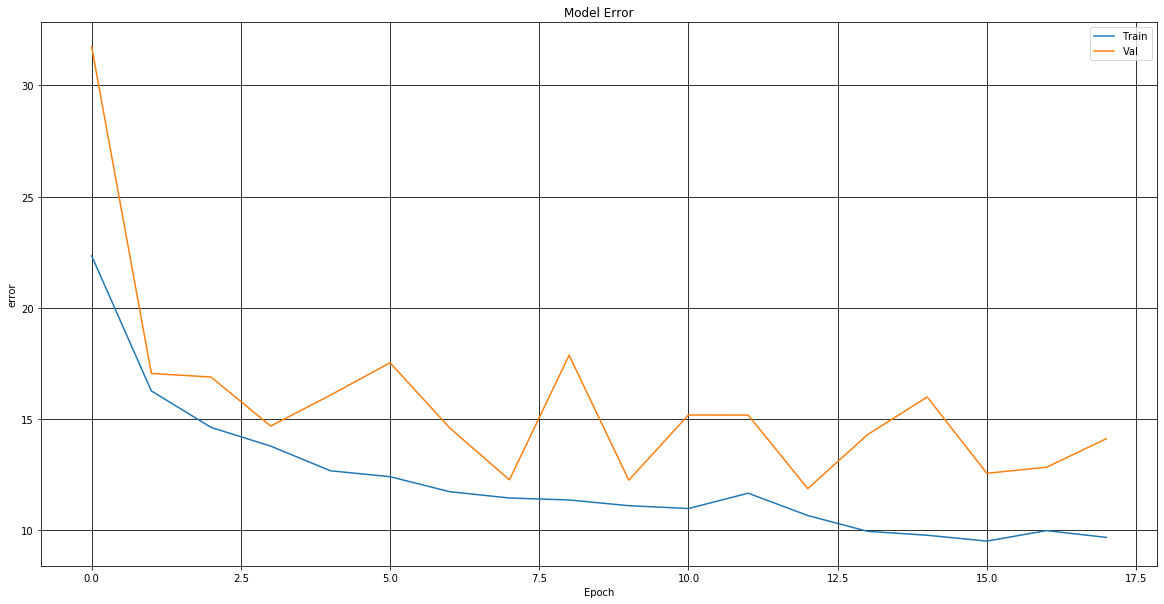

In [56]:
#early stopping
early_stopping = EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience= 5,
                              verbose=0, mode='auto')
#model checkpoint
mc = ModelCheckpoint('best_model_2.h5', monitor='val_loss', mode='min', save_best_only=True)

#reduce lr on plateau
red_lr_plat = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=0, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)

callbacks = [early_stopping,mc, red_lr_plat]

# fit model
history = model_2.fit_generator(train_generator,
                            steps_per_epoch = STEP_SIZE_TRAIN,
                            validation_data = valid_generator,
                            validation_steps = STEP_SIZE_VALID,
                            epochs = 20,
                            callbacks= callbacks)

history
plot_it(history)

#### Predicting on validation data

1024/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

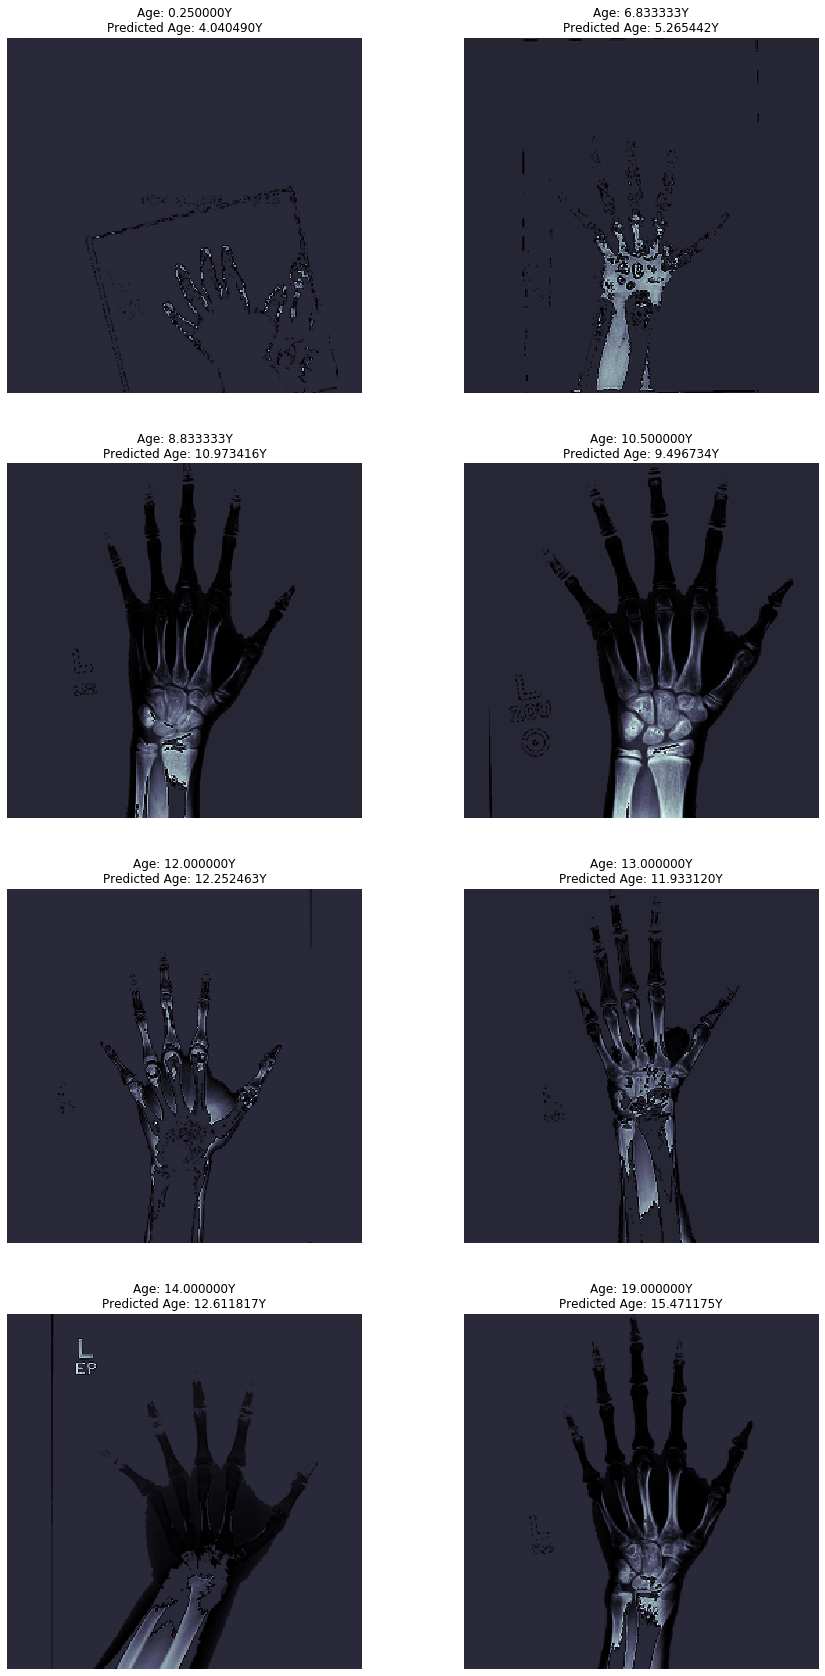

In [70]:
model_2.load_weights('best_model_2.h5')
valid_pred_2 = mean_age + std_age*(model_2.predict(test_X, batch_size = 32, verbose = True))
valid_months_2 = mean_age + std_age*(test_Y)

ord_ind_2 = np.argsort(test_Y)
ord_ind_2 = ord_ind_2[np.linspace(0, len(ord_ind_2)-1, 8).astype(int)] # take 8 evenly spaced ones
fig, axs = plt.subplots(4, 2, figsize = (15, 30))
for (ind, ax) in zip(ord_ind_2, axs.flatten()):
    ax.imshow(test_X[ind, :,:,0], cmap = 'bone')
    ax.set_title('Age: %fY\nPredicted Age: %fY' % (valid_months_2[ind]/12.0, 
                                                           valid_pred_2[ind]/12.0))
    ax.axis('off')
fig.savefig('trained_image_predictions.png', dpi = 300)

Text(0, 0.5, 'Predicted Age (Months)')

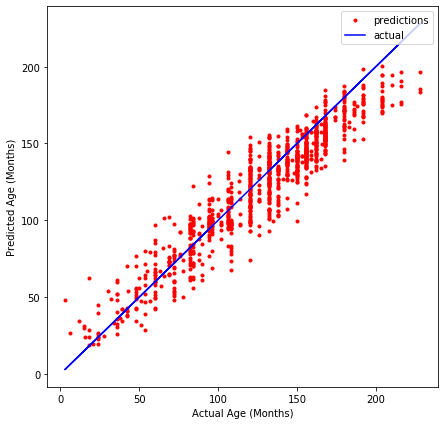

In [71]:
# Plot- precitons vs actual age using validation data
fig, ax = plt.subplots(figsize = (7,7))
ax.plot(valid_months_2, valid_pred_2, 'r.', label = 'predictions')
ax.plot(valid_months_2, valid_months_2, 'b-', label = 'actual')
ax.legend(loc = 'upper right')
ax.set_xlabel('Actual Age (Months)')
ax.set_ylabel('Predicted Age (Months)')

Text(0, 0.5, 'Frequencey')

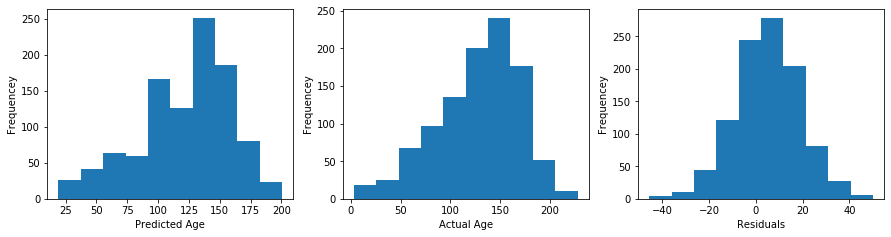

In [73]:
valid_pred_flat = list(flatten(valid_pred_2)) 
valid_pred_flat = (valid_months_2-valid_pred_flat)
fig, axes = plt.subplots(figsize=(15, 3.5), nrows=1, ncols=3)
axes[0].hist(valid_pred_2);
axes[0].set_xlabel("Predicted Age")
axes[0].set_ylabel("Frequencey")
axes[1].hist(valid_months_2);
axes[1].set_xlabel("Actual Age")
axes[1].set_ylabel("Frequencey")
axes[2].hist(valid_pred_flat);
axes[2].set_xlabel("Residuals")
axes[2].set_ylabel("Frequencey")

In [51]:
test_X_2, test_Y_2 = next(train_data_generator.flow_from_dataframe( 
                            train_df, 
                            directory = train_img_dir,
                            x_col = 'id',
                            y_col = 'scale_bone_age_z', 
                            target_size = (img_size, img_size),
                            batch_size = 4096,
                            class_mode = 'raw'
                            )) 

Found 12608 validated image filenames.


In [52]:
model_2.load_weights('best_model_2.h5')
pred_2 = mean_age + std_age*(model_2.predict(test_X_2, batch_size = 32, verbose = True))
test_months_2 = mean_age + std_age*(test_Y_2)

4096/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

Text(0, 0.5, 'Predicted Age (Months)')

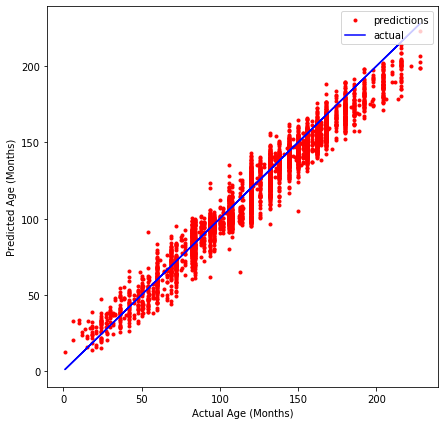

In [54]:
# Plot- precitons vs actual age using validation data
fig, ax = plt.subplots(figsize = (7,7))
ax.plot(test_months_2, pred_2, 'r.', label = 'predictions')
ax.plot(test_months_2, test_months_2, 'b-', label = 'actual')
ax.legend(loc = 'upper right')
ax.set_xlabel('Actual Age (Months)')
ax.set_ylabel('Predicted Age (Months)')

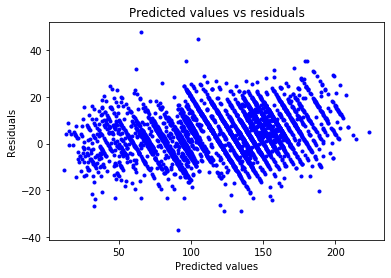

In [56]:
pred_2_flat = list(flatten(pred_2)) 
residules = (test_months_2-pred_2_flat)

plt.plot(pred_2_flat, residules, 'b.')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.title('Predicted values vs residuals')
plt.show()

Text(0, 0.5, 'Frequencey')

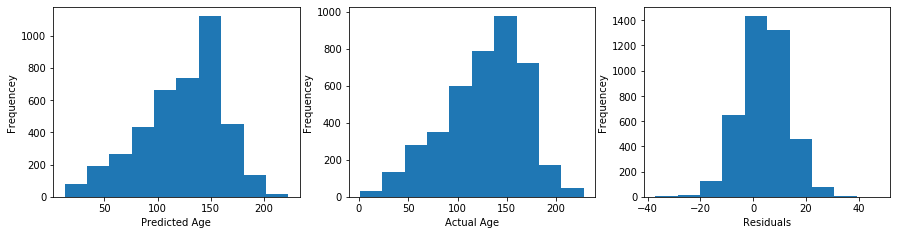

In [68]:
fig, axes = plt.subplots(figsize=(15, 3.5), nrows=1, ncols=3)
axes[0].hist(pred_2);
axes[0].set_xlabel("Predicted Age")
axes[0].set_ylabel("Frequencey")
axes[1].hist(test_months_2);
axes[1].set_xlabel("Actual Age")
axes[1].set_ylabel("Frequencey")
axes[2].hist(residules);
axes[2].set_xlabel("Residuals")
axes[2].set_ylabel("Frequencey")

### Predict on test images 

In [105]:
#Predict age from test images
test_generator.reset()
y_pred_2 = model_2.predict(test_generator)
predicted_2 = y_pred_2.flatten()
predicted_months_2 = mean_age + std_age*(predicted_2)

In [ ]:
# PLot-actual vs predicted age from test image
fig, ax = plt.subplots(figsize = (7,7))
ax.plot(test_df['Ground truth bone age (months)'], predicted_months_2, 'r.', label = 'predictions (xception)-test image')
ax.plot(test_df['Ground truth bone age (months)'], test_df['Ground truth bone age (months)'], 'b-', label = 'actual-test image')
ax.legend(loc = 'upper right')
ax.set_xlabel('Actual Age (Months)')
ax.set_ylabel('Predicted Age (Months)')

### Pre-trained model- Xception (Male-only data)

In [ ]:
#train data generator
train_generator_3 = train_data_generator.flow_from_dataframe(
    dataframe = train_df_male,
    directory = train_img_dir,
    x_col= 'id',
    y_col= 'scale_bone_age_z',
    batch_size = 32,
    seed = 42,
    shuffle = True,
    class_mode= 'raw',
    flip_vertical = True,
    color_mode = 'rgb',
    target_size = (img_size, img_size))

#validation data generator
valid_generator_3 = valid_data_generator.flow_from_dataframe(
    dataframe = valid_df_male,
    directory = valid_img_dir,
    x_col = 'Image ID',
    y_col = 'scale_bone_age_z',
    batch_size = 32,
    seed = 42,
    shuffle = True,
    class_mode = 'raw',
    flip_vertical = True,
    color_mode = 'rgb',
    target_size = (img_size, img_size))

In [ ]:
STEP_SIZE_TRAIN_3=train_generator_3.n//train_generator_3.batch_size
STEP_SIZE_VALID_3=valid_generator_3.n//valid_generator_3.batch_size
# STEP_SIZE_TEST=test_generator.n//test_generator.batch_size

In [ ]:
#early stopping
early_stopping = EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience= 5,
                              verbose=0, mode='auto')
#model checkpoint
mc = ModelCheckpoint('best_model_3.h5', monitor='val_loss', mode='min', save_best_only=True)

#reduce lr on plateau
red_lr_plat = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=0, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)

# callbacks = [tensorboard_callback,early_stopping,mc, red_lr_plat]
callbacks = [early_stopping,mc, red_lr_plat]

#fit model
history_3 = model_2.fit(train_generator_3,
                            steps_per_epoch = STEP_SIZE_TRAIN_3,
                            validation_data = valid_generator_3,
                            validation_steps = STEP_SIZE_VALID_3,
                            epochs = 20,
                            callbacks= callbacks)
history_3
plot_it(history_3)

In [ ]:
test_X_3, test_Y_3 = next(valid_data_generator.flow_from_dataframe( 
                            valid_df_male, 
                            directory = valid_img_dir,
                            x_col = 'Image ID',
                            y_col = 'scale_bone_age_z', 
                            target_size = (img_size, img_size),
                            batch_size = 256,
                            class_mode = 'raw'
                            )) 

In [ ]:
# Prediction on validation images
model_2.load_weights('best_model_3.h5')
pred_3 = mean_age + std_age*(model_2.predict(test_X_3, batch_size = 32, verbose = True))
test_months_3 = mean_age + std_age*(test_Y_3)

ord_ind_3 = np.argsort(test_Y_3)
ord_ind_3 = ord_ind_3[np.linspace(0, len(ord_ind_3)-1, 8).astype(int)] # take 8 evenly spaced ones
fig, axs = plt.subplots(4, 2, figsize = (15, 30))
for (ind, ax) in zip(ord_ind_3, axs.flatten()):
    ax.imshow(test_X_3[ind, :,:,0], cmap = 'bone')
    ax.set_title('Age: %fY\nPredicted Age: %fY' % (test_months_3[ind]/12.0, 
                                                           pred_3[ind]/12.0))
    ax.axis('off')
fig.savefig('trained_image_predictions.png', dpi = 300)

In [ ]:
# Plot- Predictions vs actual images using validation images (Male-only images)
fig, ax = plt.subplots(figsize = (7,7))
ax.plot(test_months_3, pred_3, 'r.', label = 'predictions')
ax.plot(test_months_3, test_months_3, 'b-', label = 'actual')
ax.legend(loc = 'upper right')
ax.set_xlabel('Actual Age (Months)')
ax.set_ylabel('Predicted Age (Months)')

### Pre-trained model- Xception (Female-only data)

In [ ]:
#train data generator
train_generator_f = train_data_generator.flow_from_dataframe(
    dataframe = train_df_female,
    directory = train_img_dir,
    x_col= 'id',
    y_col= 'scale_bone_age_z',
    batch_size = 32,
    seed = 42,
    shuffle = True,
    class_mode= 'raw',
    flip_vertical = True,
    color_mode = 'rgb',
    target_size = (img_size, img_size))

#validation data generator
valid_generator_f = valid_data_generator.flow_from_dataframe(
    dataframe = valid_df_female,
    directory = valid_img_dir,
    x_col = 'Image ID',
    y_col = 'scale_bone_age_z',
    batch_size = 32,
    seed = 42,
    shuffle = True,
    class_mode = 'raw',
    flip_vertical = True,
    color_mode = 'rgb',
    target_size = (img_size, img_size))

In [ ]:
STEP_SIZE_TRAIN_f=train_generator_f.n//train_generator_f.batch_size
STEP_SIZE_VALID_f=valid_generator_f.n//valid_generator_f.batch_size
# STEP_SIZE_TEST=test_generator.n//test_generator.batch_size

In [ ]:
#early stopping
early_stopping = EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience= 5,
                              verbose=0, mode='auto')
#model checkpoint
mc = ModelCheckpoint('best_model_f.h5', monitor='val_loss', mode='min', save_best_only=True)

#reduce lr on plateau
red_lr_plat = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=0, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)

# callbacks = [tensorboard_callback,early_stopping,mc, red_lr_plat]
callbacks = [early_stopping,mc, red_lr_plat]

#fit model
history_f = model_2.fit(train_generator_f,
                            steps_per_epoch = STEP_SIZE_TRAIN_f,
                            validation_data = valid_generator_f,
                            validation_steps = STEP_SIZE_VALID_f,
                            epochs = 20,
                            callbacks= callbacks)
history_f
plot_it(history_f)

In [ ]:
test_X_f, test_Y_f = next(valid_data_generator.flow_from_dataframe( 
                            valid_df_female, 
                            directory = valid_img_dir,
                            x_col = 'Image ID',
                            y_col = 'scale_bone_age_z', 
                            target_size = (img_size, img_size),
                            batch_size = 256,
                            class_mode = 'raw'
                            )) 

In [ ]:
# Prediction on validation images
model_2.load_weights('best_model_3.h5')
pred_f = mean_age + std_age*(model_2.predict(test_X_f, batch_size = 32, verbose = True))
test_months_f = mean_age + std_age*(test_Y_f)

ord_ind_f = np.argsort(test_Y_f)
ord_ind_f = ord_ind_f[np.linspace(0, len(ord_ind_f)-1, 8).astype(int)] # take 8 evenly spaced ones
fig, axs = plt.subplots(4, 2, figsize = (15, 30))
for (ind, ax) in zip(ord_ind_f, axs.flatten()):
    ax.imshow(test_X_f[ind, :,:,0], cmap = 'bone')
    ax.set_title('Age: %fY\nPredicted Age: %fY' % (test_months_f[ind]/12.0, 
                                                           pred_f[ind]/12.0))
    ax.axis('off')
fig.savefig('trained_image_predictions.png', dpi = 300)

In [ ]:
# Plot- Predictions vs actual images using validation images (Male-only images)
fig, ax = plt.subplots(figsize = (7,7))
ax.plot(test_months_f, pred_f, 'r.', label = 'predictions')
ax.plot(test_months_f, test_months_f, 'b-', label = 'actual')
ax.legend(loc = 'upper right')
ax.set_xlabel('Actual Age (Months)')
ax.set_ylabel('Predicted Age (Months)')

In [ ]:
# Prediction on test data
# test_generator.reset()
# y_pred = model_2.predict(test_generator)
# predicted = y_pred.flatten()
# predicted_months = mean_bone_age + std_bone_age*(predicted)
# filenames=test_generator.filenames
# results=pd.DataFrame({"Filename":filenames,
#                       "Predictions": predicted_months})
# results.to_csv("results.csv",index=False)
# results.head()